In [15]:
citation("DropletUtils")


Lun ATL, Riesenfeld S, Andrews T, Dao T, Gomes T, participants in the
1st Human Cell Atlas Jamboree, Marioni JC (2019). “EmptyDrops:
distinguishing cells from empty droplets in droplet-based single-cell
RNA sequencing data.” _Genome Biol._, *20*, 63. doi:
10.1186/s13059-019-1662-y (URL:
https://doi.org/10.1186/s13059-019-1662-y).

Griffiths JA, Richard AC, Bach K, Lun ATL, Marioni JC (2018).
“Detection and removal of barcode swapping in single-cell RNA-seq
data.” _Nat. Commun._, *9*(1), 2667. doi: 10.1038/s41467-018-05083-x
(URL: https://doi.org/10.1038/s41467-018-05083-x).

To see these entries in BibTeX format, use 'print(<citation>,
bibtex=TRUE)', 'toBibtex(.)', or set
'options(citation.bibtex.max=999)'.


In [1]:
library(DropletUtils)
library(Seurat)
library(scater)
library(Matrix)
library(TxDb.Mmusculus.UCSC.mm10.ensGene)
library(scran)
library(BiocSingular)
library(liger)
library(SeuratWrappers)
library(dplyr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

In [ ]:
barcode_rank_threshold = 500
droplet_utils_FDR = 0.001
mito_threshold = 1
neighbor_value = 10
dim_count = 30

preProcess <- function (sample_directory){
sce <- read10xCounts(sample_directory, col.names = TRUE, type = c("auto"), version = ('3'))
rowDataInfo <- (rowData(sce))
Symbols <- (rowDataInfo[,2])
duplicateNumber <- 1
while (length(Symbols[duplicated(Symbols)])> 0)
{
    duplicateString <- toString(duplicateNumber)
    duplicate_symbols <- Symbols[duplicated(Symbols)]
    replacements <- paste0(Symbols[duplicated(Symbols)],'-',duplicateString)
    redundant_indexes <- match(duplicate_symbols,Symbols)
    Symbols[redundant_indexes] <- replacements
    row.names(sce) <- Symbols
    duplicateNumber <- duplicateNumber + 1
}
my.counts <- (counts(sce))
e.out <- emptyDrops(my.counts, lower=barcode_rank_threshold)
is.cell <- e.out$FDR <= droplet_utils_FDR
sce <- sce[,which(e.out$FDR <= 0.001)]
sce <- addPerCellQC(sce)

return(sce)
    
}

ctl1 <- preProcess('XXX')
ctl2 <- preProcess('XXX')
ko1 <- preProcess('XXX')
ko2 <- preProcess('XXX')

ctl1 <- as.Seurat(ctl1, counts = "counts", data = "counts", assay = "RNA", project = "SingleCellExperiment")
ko1 <- as.Seurat(ko1, counts = "counts", data = "counts", assay = "RNA", project = "SingleCellExperiment")
ctl2 <- as.Seurat(ctl2, counts = "counts", data = "counts", assay = "RNA", project = "SingleCellExperiment")
ko2 <- as.Seurat(ko2, counts = "counts", data = "counts", assay = "RNA", project = "SingleCellExperiment")
allen.cells <- readRDS(file = 'XXX')

Idents(allen.cells) <- "allen.class"
include <- c('GABAergic','Endothelial','Glutamatergic','Non-Neuronal')
allen.filtered <- subset(allen.cells, idents = c('GABAergic','Endothelial','Glutamatergic','Non-Neuronal'))

allen.filtered$Sample <- 'allen'
ctl1$Sample <- 'ctl1'
ko1$Sample <- 'ko1'
ctl2$Sample <- 'ctl2'
ko2$Sample <- 'ko2'

allen.filtered$condition <- 'allen'
ctl1$condition <- 'ctl'
ko1$condition <- 'ko'
ctl2$condition <- 'ctl'
ko2$condition <- 'ko'

sce.merge <- merge(allen.filtered, y = c(ctl1,ctl2,ko1,ko2))
sce.merge <- FindVariableFeatures(sce.merge,selection.method = "vst", nfeatures = 10000)
oldFeatures <- VariableFeatures(sce.merge)
newFeatures <- c('Slc17a7','Camk2a','Slc17a6','Grin1','Grin2b')
currentFeatures <- unique(c(oldFeatures,newFeatures))
VariableFeatures(sce.merge) <- currentFeatures
sce.merge <- ScaleData(sce.merge, split.by = "Sample", do.center = FALSE)
sce.merge <- RunOptimizeALS(sce.merge, k = dim_count, lambda = 1.0, split.by = "Sample")
sce.merge <- RunQuantileNorm(sce.merge, split.by = "Sample")
sce.merge <- FindNeighbors(sce.merge, reduction = "iNMF", dims = 1:dim_count)
sce.merge <- FindClusters(sce.merge, resolution = 0.3)
sce.merge <- RunUMAP(sce.merge, dims = 1:dim_count, reduction = "iNMF")
saveRDS(sce.merge, 'XXX')

In [ ]:
# calculate_nearest_neighbors <- function(){

readRDS('nr1_liger_flx_expand_v6.rds')

just.allen <- subset(sce.merge, condition == 'allen')
our.data <- subset(sce.merge, condition == 'allen',invert = TRUE)

allen.vectors <- Embeddings(object = just.allen[['iNMF']])[,(1:dim_count)]  #removes the second dimension
our.vectors <- Embeddings(object = our.data[['iNMF']])[,(1:dim_count)]  #removes the scond dimensions

neighbor.classes <- c()
euclidean.distances <- c()
neighbor.categories <- c()
neighbor.groups <- c()

for (i in 1:dim(our.vectors)[1]){
    nearest.neighbor <- sort(sqrt(rowSums((sweep(allen.vectors,2,our.vectors[i,],'-')^2))))[1:neighbor_value]
    euclidean.distance <- nearest.neighbor[[1]]
    closest.allen.cells <- names(nearest.neighbor)
    neighborhood_classes <- unlist(just.allen[[]][closest.allen.cells,4])
    weights <- 1/nearest.neighbor
    weights.df <- data.frame(neighborhood_classes, weights)
    summed_neighbor_weights <- tapply(weights.df$weights, weights.df$neighborhood_classes, FUN=sum)
    neighbor.class <- names(which.max(summed_neighbor_weights))
    class.index <- which(just.allen[[]]$allen.cluster == neighbor.class)[1]
    neighbor.categories <- rbind(neighbor.categories,just.allen[[]]$allen.sub.class	[class.index])
    neighbor.groups <- rbind(neighbor.groups,just.allen[[]]$allen.class[class.index])
    neighbor.classes <- rbind(neighbor.classes,neighbor.class)
    euclidean.distances <- rbind(euclidean.distances,euclidean.distance)
}

for (i in 1:dim(just.allen)[2]){
    euclidean.distances <- rbind(0, euclidean.distances)
}

neighbor.classes <- c(c(just.allen[[]][,4][1:length(just.allen[[]][,4])]), c(neighbor.classes))
neighbor.categories <- c(c(just.allen[[]][,5][1:length(just.allen[[]][,5])]), c(neighbor.categories))
neighbor.groups <- c(c(just.allen[[]][,6][1:length(just.allen[[]][,6])]), c(neighbor.groups))

sce.merge$neighbors <- c(unlist(neighbor.classes))
sce.merge$distance <- c(euclidean.distances)
sce.merge$categories <- c(unlist(neighbor.categories))
sce.merge$groups <- c(unlist(neighbor.groups))

saveRDS(sce.merge,'nr1_liger_flx_expand_v6.rds')

In [2]:
sce.merge <- readRDS('nr1_liger_flx_expand_v6.rds')

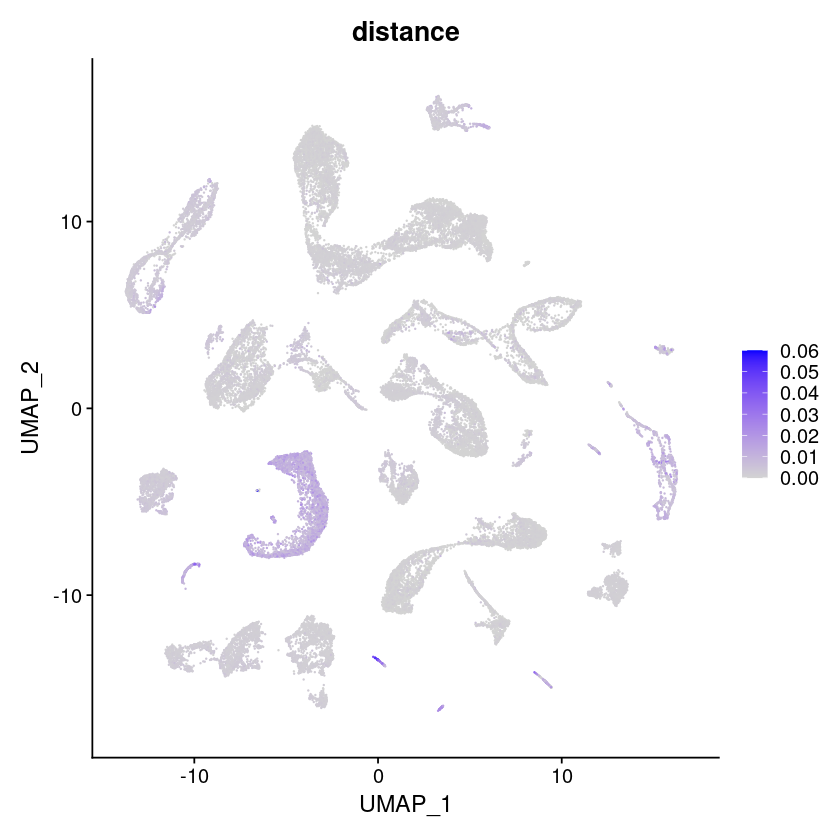

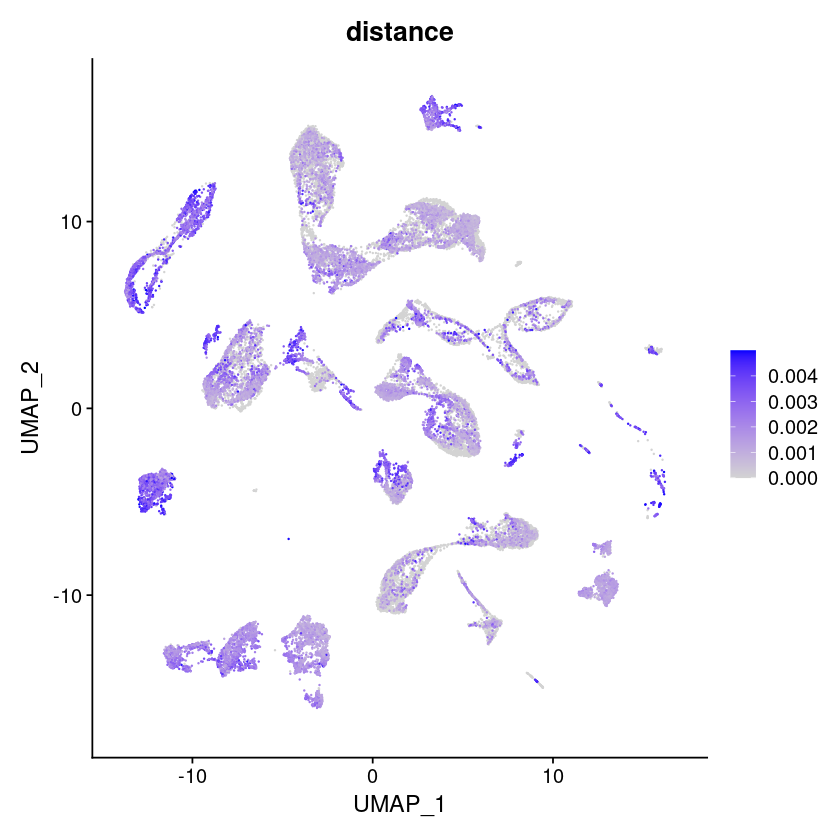

In [3]:
FeaturePlot(sce.merge, features = 'distance', max.cutoff = 0.06)
sce.euclid.filtered <- subset(sce.merge, subset = distance < 0.005)
FeaturePlot(sce.euclid.filtered, features = 'distance', max.cutoff = 0.06)

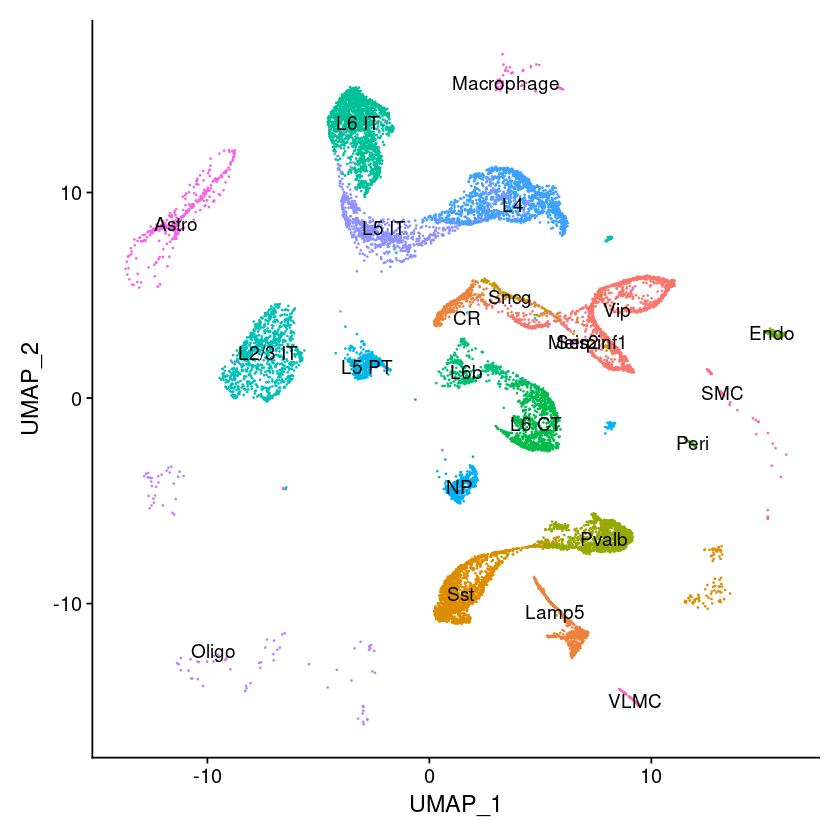

In [4]:
#various umap plots
just.allen <- subset(sce.euclid.filtered, subset = Sample == "allen")
Idents(just.allen) <- "allen.sub.class"

DimPlot(just.allen, reduction = "umap", label = TRUE) + NoLegend()

just.ko <- subset(sce.euclid.filtered, subset = condition == "ko")
just.ctl <- subset(sce.euclid.filtered, subset = condition == "ctl")#mito percent

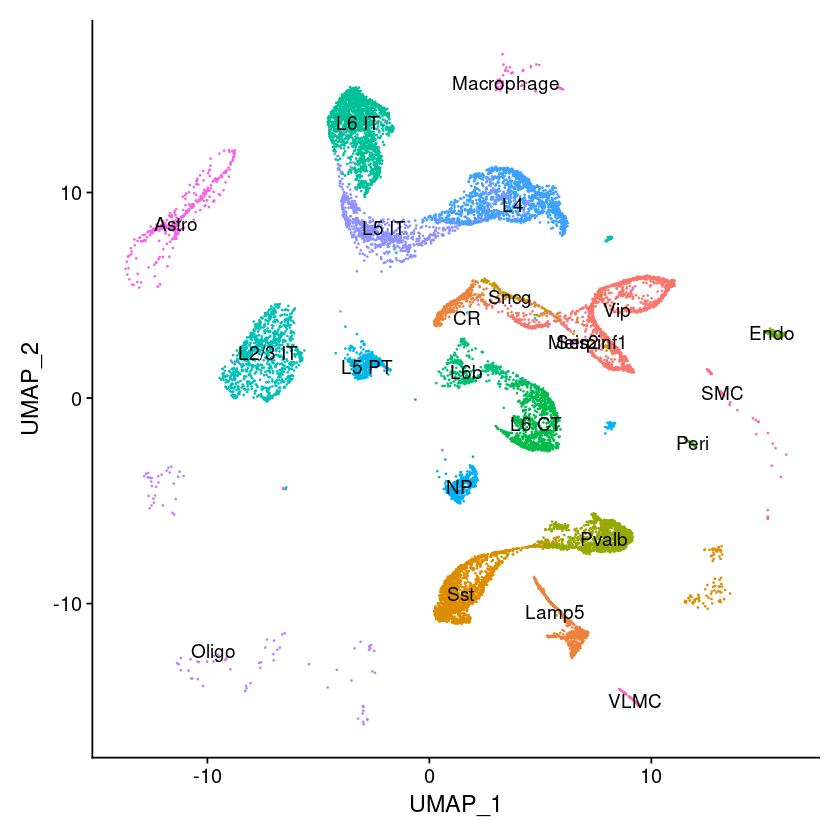

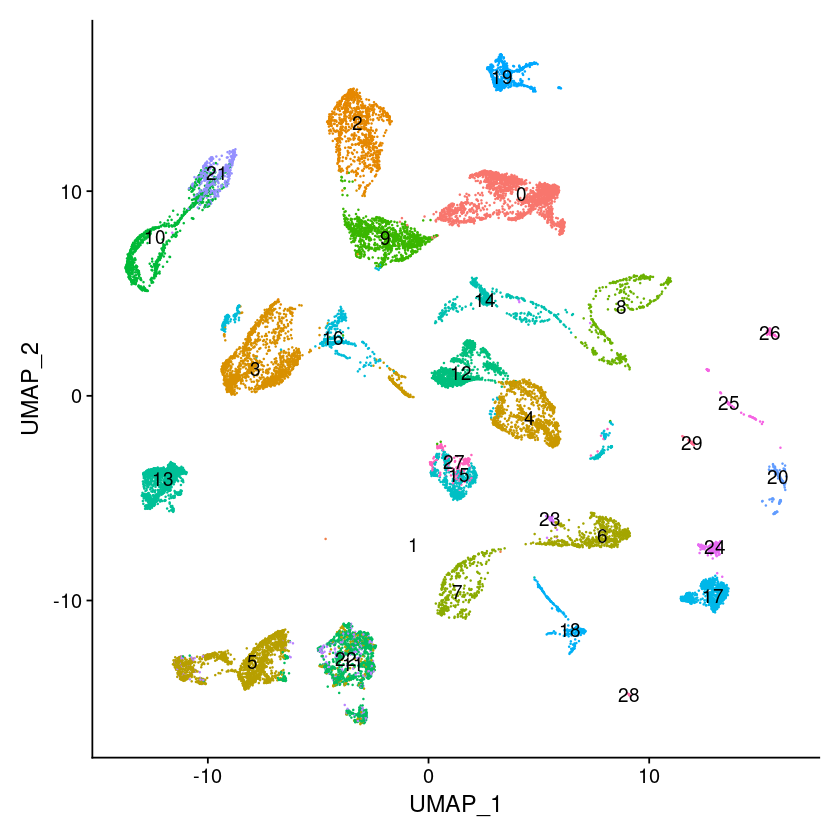

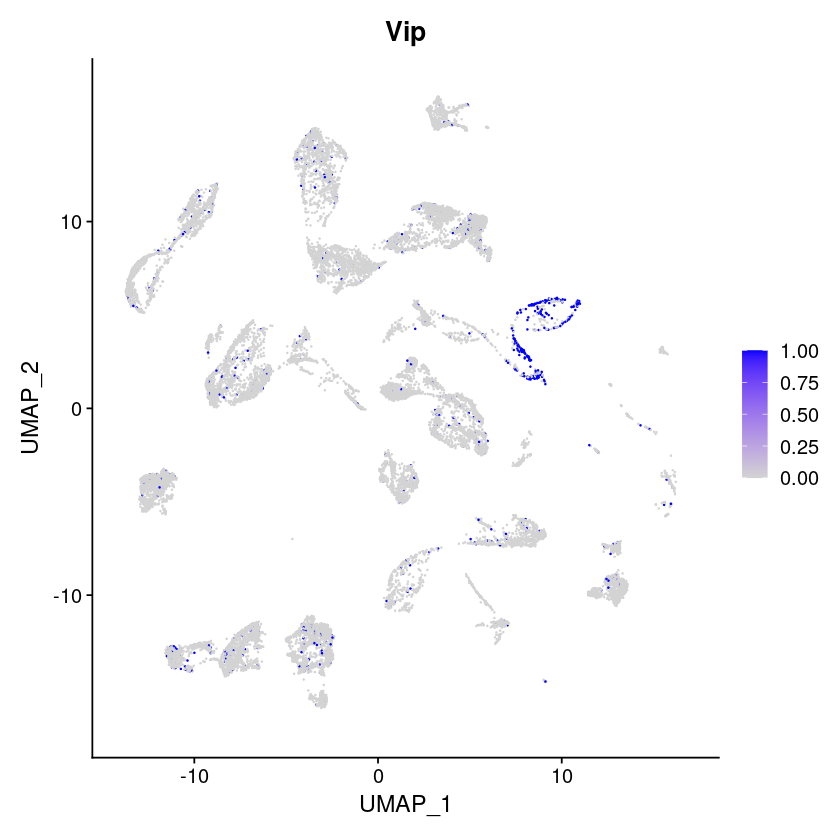

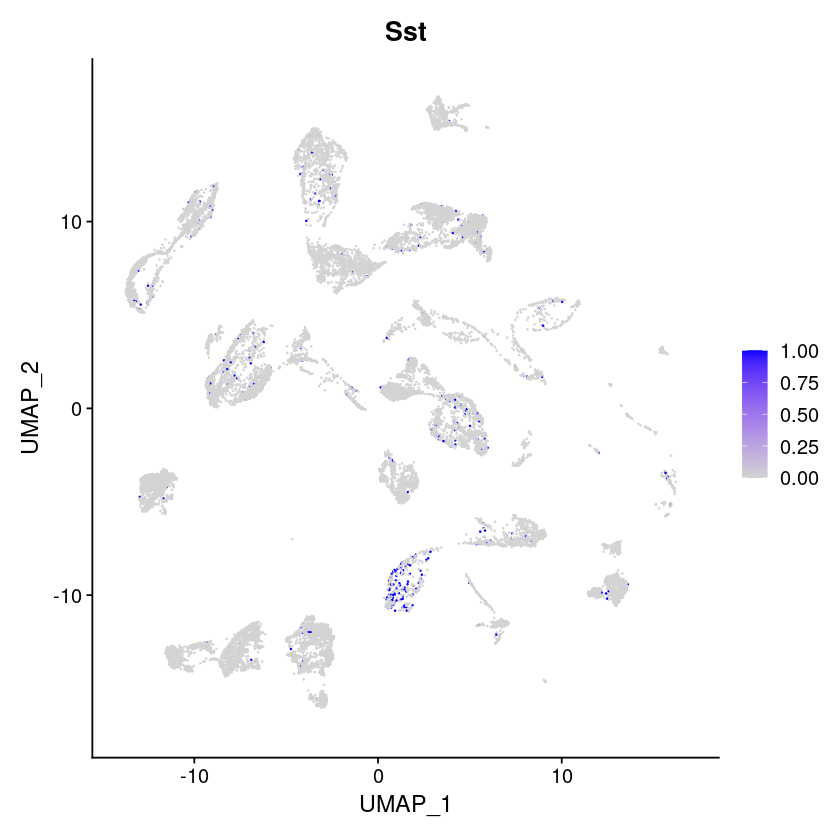

Warning message:
“Removed 24 rows containing non-finite values (stat_ydensity).”


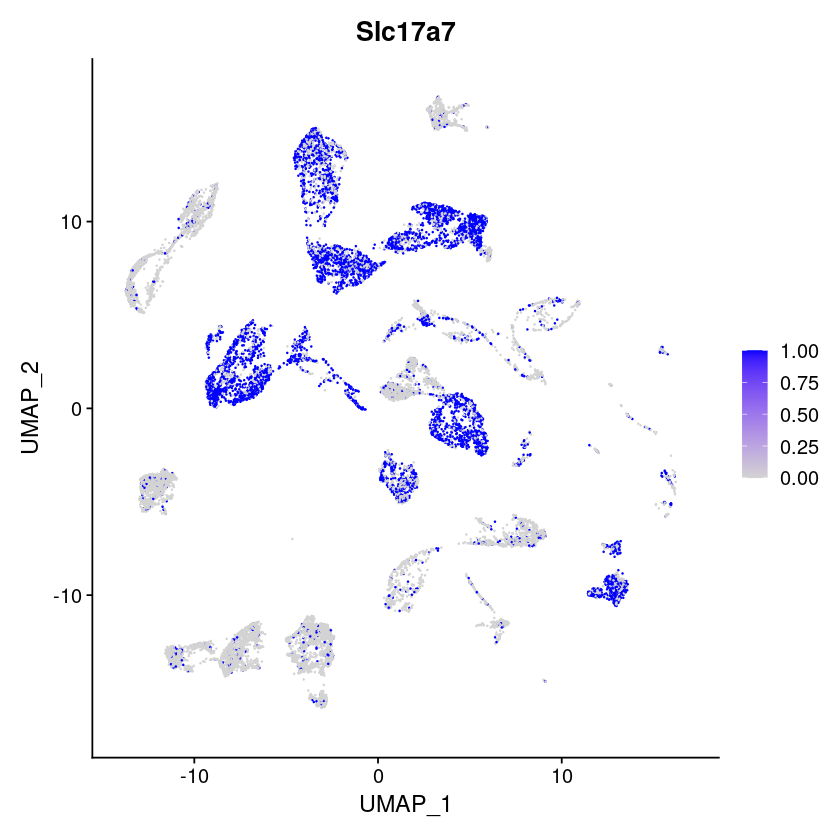

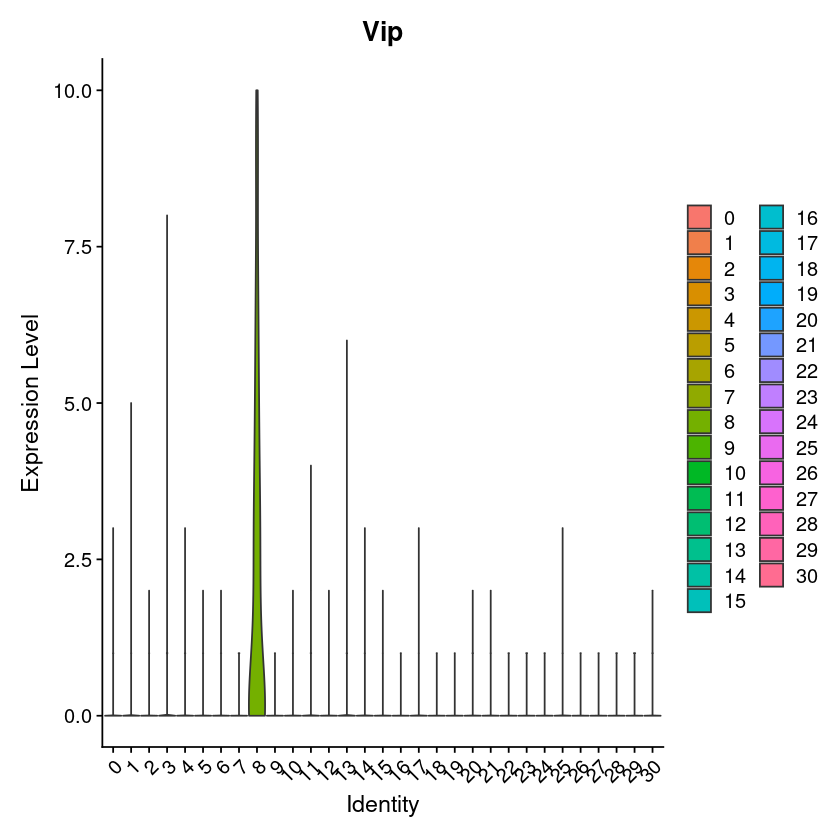

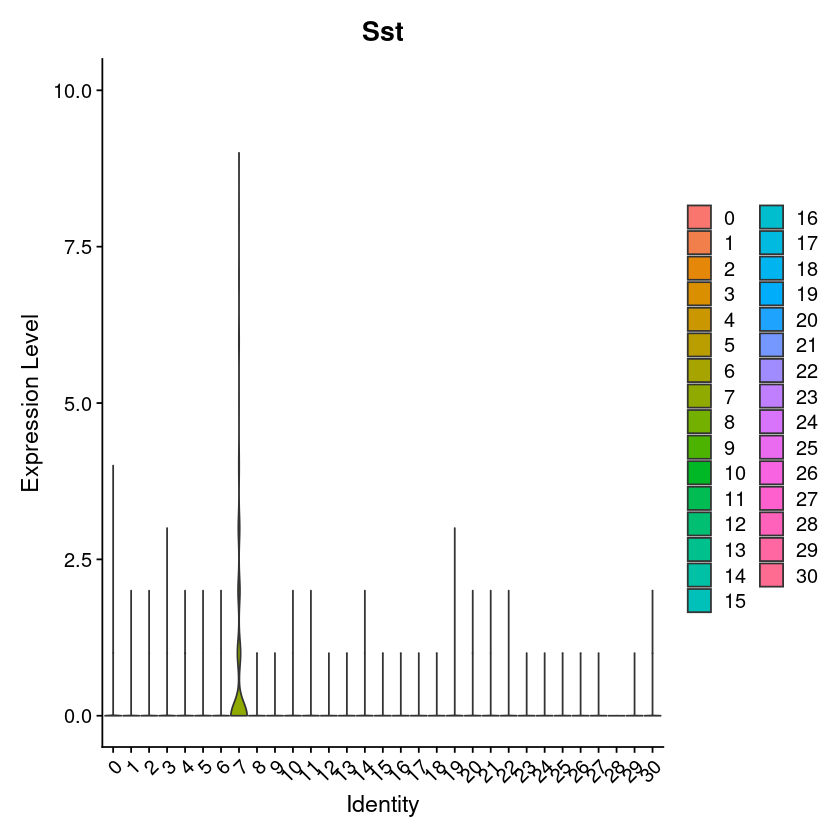

In [5]:
#panels for cluster identification

just.tenx <- subset(sce.euclid.filtered, subset = Sample == "allen", invert = TRUE)
DimPlot(just.allen, reduction = "umap", label = TRUE) + NoLegend()
Idents(object = just.tenx) <- 'RNA_snn_res.0.3'
DimPlot(just.tenx, reduction = "umap", label = TRUE) + NoLegend()
FeaturePlot(just.tenx, features = 'Vip', max.cutoff = 1)
FeaturePlot(just.tenx, features = 'Sst', max.cutoff = 1)
FeaturePlot(just.tenx, features = 'Slc17a7', max.cutoff = 1)


#check Vip and Sst expression in violin plot using clusters to confirm
just.tenx <- subset(sce.merge, subset = Sample == "allen", invert = TRUE)
Idents(just.tenx) <- "RNA_snn_res.0.3"
VlnPlot(just.tenx, features = 'Vip', pt.size = 0, y.max = 10)
VlnPlot(just.tenx, features = 'Sst', pt.size = 0, y.max = 10)
#Sst is cluster 7 and Vip is cluster 8

In [6]:
# recode the samples and make subgroups

large_groups <- recode(sce.euclid.filtered[[]]$categories, 'L6 CT' = 'L6','L6 IT' = 'L6','L6b' = 'L6','L5 PT' = 'L5','L5 IT' = 'L5',
                       'L2/3 IT' = 'L2/3','Astro' = 'nonNeuronal', 'SMC' = 'nonNeuronal', 'Peri' = 'nonNeuronal', 
                       'Oligo' = 'nonNeuronal', 'VLMC' = 'nonNeuronal', 'Endo' = 'nonNeuronal', 'Macrophage' = 'nonNeuronal',
                      'Meis2' = 'otherInterneurons', 'Lamp5' = 'otherInterneurons', 'Sncg' = 'otherInterneurons',
                       'Serpinf1' = 'otherInterneurons', 'NP' = 'L5', 'Vip' = 'otherInterneurons', 'Sst' = 'otherInterneurons')
sce.euclid.filtered$large_groups <- large_groups

#recode cluster 8 to vip
tempDF <- sce.euclid.filtered[[]] %>% mutate(large_groups = ifelse(RNA_snn_res.0.3 == 8,'Vip',large_groups))
sce.euclid.filtered$large_groups <- tempDF$large_groups

#recode cluster 7 to Sst
tempDF <- sce.euclid.filtered[[]] %>% mutate(large_groups = ifelse(RNA_snn_res.0.3 == 7,'Sst',large_groups))
sce.euclid.filtered$large_groups <- tempDF$large_groups

#subset the large groups
Idents(object = sce.euclid.filtered) <- 'large_groups'
sce.select <- subset(sce.euclid.filtered, idents = c("CR","nonNeuronal","otherInterneurons"), invert = TRUE)

levels(sce.select) <- c("Vip","Sst","Pvalb","L6", "L5","L4","L2/3")

allen.select <- subset(sce.select, subset = condition == "allen")
tenx.select <- subset(sce.select, subset = condition == 'allen', invert = TRUE)

In [7]:
tenx.select[["percent.mt"]] <- PercentageFeatureSet(tenx.select, pattern = "^mt-")
tenx.select.filtered <- subset(tenx.select, subset = nCount_RNA > 500 & percent.mt < 1)
tenx.select.filtered

An object of class Seurat 
47924 features across 10977 samples within 1 assay 
Active assay: RNA (47924 features, 10003 variable features)
 3 dimensional reductions calculated: iNMF_raw, iNMF, umap

In [8]:
tenx.select[["percent.mt"]] <- PercentageFeatureSet(tenx.select, pattern = "^mt-")
tenx.select.filtered <- subset(tenx.select, subset = nCount_RNA > 500 & percent.mt < 1)

tenx.select.filtered$large_groups <- factor(tenx.select.filtered$large_groups, levels = c("L2/3","L4","L5","L6", "Pvalb","Sst","Vip"))
Idents(object = tenx.select.filtered) <- 'condition'
tenx.select.filtered.post.norm <- NormalizeData(tenx.select.filtered, normalization.method = 'RC')

tenx.select.filtered.post.norm[["percent.mt"]] <- PercentageFeatureSet(tenx.select.filtered.post.norm, pattern = "^mt-")

#setup the coverage plots
Idents(tenx.select.filtered.post.norm) <- "condition"
ko <- WhichCells(tenx.select.filtered.post.norm, idents = c("ko"))
ctl <- WhichCells(tenx.select.filtered.post.norm, idents = c( "ctl"))
ctl_cell_coverage <- DimPlot(tenx.select.filtered.post.norm, cells.highlight= list(ctl), cols.highlight = c("blue"),pt.size = 1, cols= "grey")
ko_cell_coverage <- DimPlot(tenx.select.filtered.post.norm, cells.highlight= list(ko), cols.highlight = c("red"), cols= "grey")


pdf('/home_fmi/01/otoosean/home_faimsrv01/Sequel/figures/nr1_analysis_flx_v6.pdf')

Idents(object = tenx.select.filtered.post.norm) <- 'condition'
VlnPlot(tenx.select.filtered.post.norm, features = 'Grin1flx', split.by = 'large_groups', pt.size = 0.4, y.max = 5,
       slot = 'data', adjust = 1) + 
ggplot2::scale_fill_manual(values = c('green', 'blue','purple','gray','red','yellow','orange'))

Idents(object = tenx.select.filtered.post.norm) <- 'large_groups'

DimPlot(tenx.select.filtered.post.norm, label = TRUE)  + ggtitle('Assigned group identities in tenx data')
ctl_cell_coverage + ggtitle('Ctl cell coverage')
ko_cell_coverage + ggtitle('Ko cell coverage')

Idents(object = tenx.select.filtered.post.norm) <- 'condition'
VlnPlot(tenx.select.filtered.post.norm, features = 'percent.mt', split.by = 'large_groups', pt.size = 0, y.max = 0.5)
VlnPlot(tenx.select.filtered.post.norm, features = 'nCount_RNA', split.by = 'large_groups', pt.size = 0)

VlnPlot(tenx.select.filtered.post.norm, features = 'Slc17a7', split.by = 'large_groups', pt.size = 0.4, y.max = 10,
       slot = 'data', adjust = 1) + 
ggplot2::scale_fill_manual(values = c('green', 'blue','purple','gray','red','yellow','orange'))

VlnPlot(tenx.select.filtered.post.norm, features = 'Gad1', split.by = 'large_groups', pt.size = 0.4, y.max = 10,
       slot = 'data', adjust = 1) + 
ggplot2::scale_fill_manual(values = c('green', 'blue','purple','gray','red','yellow','orange'))

Idents(object = tenx.select.filtered.post.norm) <- 'large_groups'
levels(tenx.select.filtered.post.norm) <- c("Vip","Sst","Pvalb","L6", "L5","L4","L2/3")

markers.to.plot <- c('Slc17a7','Lamp5','Rorb','Deptor','Bcl11b','Gad1','Pvalb',   #Bcl11b - aka Ctip2
                     'Sst', 'Vip')

DotPlot(tenx.select.filtered.post.norm, features = rev(markers.to.plot), dot.scale = 10,
       col.max = 1, col.min = 0, scale.max = 40) + RotatedAxis() +
ggtitle('dot plot tenx')
DotPlot(allen.select, features = rev(markers.to.plot), dot.scale = 10) + RotatedAxis() +
ggtitle('dot plot allen')
dev.off()

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“Removed 493 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 493 rows containing missing values (geom_point).”
Warning message:
“Removed 228 rows containing non-finite values (stat_ydensity).”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“Removed 333 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 333 rows containing missing values (geom_point).”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“Removed 76 rows containi

png 
  2

In [9]:
saveRDS(tenx.select.filtered.post.norm,'nr1_post_processing')

In [26]:
print('Vip')
vip <- subset(test, subset = large_groups == 'Vip')
table(vip$condition)
Idents(vip) <- "condition"
vip.diff <- FindMarkers(vip, ident.1 = "ctl", ident.2 = 'ko', only.pos = FALSE, slot = "data", 
                        features = c('Grin1','mCherry','Grin1flx'),
                        test.use = 'wilcox',
                        logfc.threshold = 0)
vip.diff[c('Grin1flx','mCherry','Grin1'),]

[1] "Vip"



ctl  ko 
265 122 

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Grin1flx,4.462283e-05,-0.9319394,0.430,0.189,1
mCherry,9.028356e-02,-39.3706185,0.498,0.369,1
Grin1,7.206482e-05,2.1223187,0.362,0.156,1


In [44]:
test <- tenx.select.filtered.post.norm

print('Vip')
vip <- subset(test, subset = large_groups == 'Vip')
table(vip$condition)
Idents(vip) <- "condition"
vip.diff <- FindMarkers(vip, ident.1 = "ctl", ident.2 = 'ko', only.pos = FALSE, slot = "counts", 
                        features = c('Grin1','mCherry','Grin1flx'),
                        test.use = 'wilcox',
                        logfc.threshold = 0)
vip.diff[c('Grin1flx','mCherry','Grin1'),]

print('Pvalb')
pv <- subset(test, subset = large_groups == 'Pvalb')
table(pv$condition)
Idents(pv) <- "condition"
pv.diff <- FindMarkers(pv, ident.1 = "ctl", ident.2 = 'ko', only.pos = FALSE, slot = "counts", 
                        features = c('Grin1','mCherry','Grin1flx'),
                        test.use = 'wilcox',
                        logfc.threshold = 0)
pv.diff[c('Grin1flx','mCherry','Grin1'),]

print('Sst')
sst <- subset(test, subset = large_groups == 'Sst')
table(sst$condition)
Idents(sst) <- "condition"
sst.diff <- FindMarkers(sst, ident.1 = "ctl", ident.2 = 'ko', only.pos = FALSE, slot = "counts", 
                        features = c('Grin1','mCherry','Grin1flx'),
                        test.use = 'wilcox',
                        logfc.threshold = 0)
sst.diff[c('Grin1flx','mCherry','Grin1'),]

print('Layer 6')
l6 <- subset(test, subset = large_groups == 'L6')
table(l6$condition)
Idents(l6) <- "condition"
l6.diff <- FindMarkers(l6, ident.1 = "ctl", ident.2 = 'ko', only.pos = FALSE, slot = "counts", 
                        features = c('Grin1','mCherry','Grin1flx'),
                       test.use = 'wilcox',
                       logfc.threshold = 0)
l6.diff[c('Grin1flx','mCherry','Grin1'),]

print('Layer 5')
l5 <- subset(test, subset = large_groups == 'L5')
table(l5$condition)
Idents(l5) <- "condition"
l5.diff <- FindMarkers(l5, ident.1 = "ctl", ident.2 = 'ko', only.pos = FALSE, slot = "counts", 
                        features = c('Grin1','mCherry','Grin1flx'),
                       test.use = 'wilcox',
                       logfc.threshold = 0)
l5.diff[c('Grin1flx','mCherry','Grin1'),]

print('Layer 4')
l4 <- subset(test, subset = large_groups == 'L4')
table(l4$condition)
Idents(l4) <- "condition"
l4.diff <- FindMarkers(l4, ident.1 = "ctl", ident.2 = 'ko', only.pos = FALSE, slot = "counts", 
                        features = c('Grin1','mCherry','Grin1flx'),
                       test.use = 'wilcox',
                       logfc.threshold = 0)
l4.diff[c('Grin1flx','mCherry','Grin1'),]

print('Layer 2/3')
l23 <- subset(test, subset = large_groups == 'L2/3')
table(l23$condition)
Idents(l23) <- "condition"
l23.diff <- FindMarkers(l23, ident.1 = "ctl", only.pos = FALSE, slot = "counts", 
                        features = c('Grin1','mCherry','Grin1flx'),
                        test.use = 'wilcox',
                        logfc.threshold = 0)
l23.diff[c('Grin1flx','mCherry','Grin1'),]

[1] "Vip"



ctl  ko 
265 122 

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Grin1flx,1.245283e-05,0.23988643,0.430,0.189,0.5967895
mCherry,5.613893e-02,0.08999016,0.498,0.369,1.0000000
Grin1,2.197608e-05,0.25391064,0.362,0.156,1.0000000


[1] "Pvalb"



ctl  ko 
350 307 

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Grin1flx,1.712280e-15,0.3234359,0.389,0.117,8.205931e-11
mCherry,6.312332e-04,-0.4349229,0.440,0.531,1.000000e+00
Grin1,2.153863e-05,0.1591840,0.331,0.186,1.000000e+00


[1] "Sst"



ctl  ko 
189 157 

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Grin1flx,5.031484e-12,0.3673603,0.513,0.153,2.411289e-07
mCherry,1.993235e-01,0.1505544,0.455,0.401,1.000000e+00
Grin1,1.096045e-08,0.2863851,0.487,0.191,5.252688e-04


[1] "Layer 6"



 ctl   ko 
1442 1718 

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Grin1flx,5.256251e-183,0.5762923,0.567,0.091,2.519006e-178
mCherry,2.836674e-03,-0.1210305,0.370,0.290,1.000000e+00
Grin1,4.983070e-97,0.3828653,0.428,0.109,2.388087e-92


[1] "Layer 5"



 ctl   ko 
 954 1570 

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Grin1flx,1.305447e-70,0.3647715,0.545,0.194,6.256225e-66
mCherry,2.086911e-06,0.4873303,0.336,0.259,1.000131e-01
Grin1,2.236422e-32,0.2575605,0.398,0.189,1.071783e-27


[1] "Layer 4"



 ctl   ko 
1272  839 

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Grin1flx,9.330201e-43,0.3056187,0.612,0.282,4.471406e-38
mCherry,5.548445e-64,0.7383679,0.522,0.179,2.659037e-59
Grin1,4.163068e-36,0.3362784,0.448,0.197,1.995109e-31


[1] "Layer 2/3"



ctl  ko 
918 874 

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Grin1flx,4.766430e-40,0.3248494,0.643,0.315,2.284264e-35
mCherry,3.275512e-141,1.8012876,0.716,0.167,1.569756e-136
Grin1,8.096970e-30,0.3022151,0.465,0.221,3.880392e-25


In [11]:
path = 'XXX'

pdf(path, width =10, height =5)
Idents(object = tenx.select.filtered.post.norm) <- 'condition'
VlnPlot(tenx.select.filtered.post.norm, features = 'Grin1flx', split.by = 'large_groups', pt.size = 0, y.max = 5,
       slot = 'data', adjust = 1) + theme(legend.position = 'none') +
ggplot2::scale_fill_manual(values = c('gray', 'gray','gray','gray','gray','gray','gray'))
dev.off()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“Removed 493 rows containing non-finite values (stat_ydensity).”


png 
  2

In [112]:
l23.diff <- FindMarkers(l23, ident.1 = "ctl", only.pos = FALSE, 
                        test.use = 't',
                        logfc.threshold = 20)

In [114]:
new.df <- l23.diff[l23.diff$p_val_adj < 0.000001,]
new.df[order(new.df$avg_logFC),]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tenm2,9.416046e-30,-97.13206,0.999,0.957,4.512546e-25
Tspoap1,2.458299e-46,-80.87874,0.675,0.823,1.178115e-41
Rbfox1,1.706806e-48,-78.18824,0.997,0.986,8.179695e-44
Kcnip4,2.768090e-44,-74.45210,1.000,0.989,1.326579e-39
Snrnp70,8.273048e-41,-62.82529,0.946,0.955,3.964776e-36
H2-K1,6.693685e-22,-55.93386,0.014,0.325,3.207881e-17
Mcf2l,6.788757e-27,-55.77058,0.538,0.625,3.253444e-22
Sgcz,4.543557e-32,-51.87974,0.969,0.760,2.177454e-27
Cacnb2,1.754303e-15,-48.72733,0.886,0.789,8.407323e-11


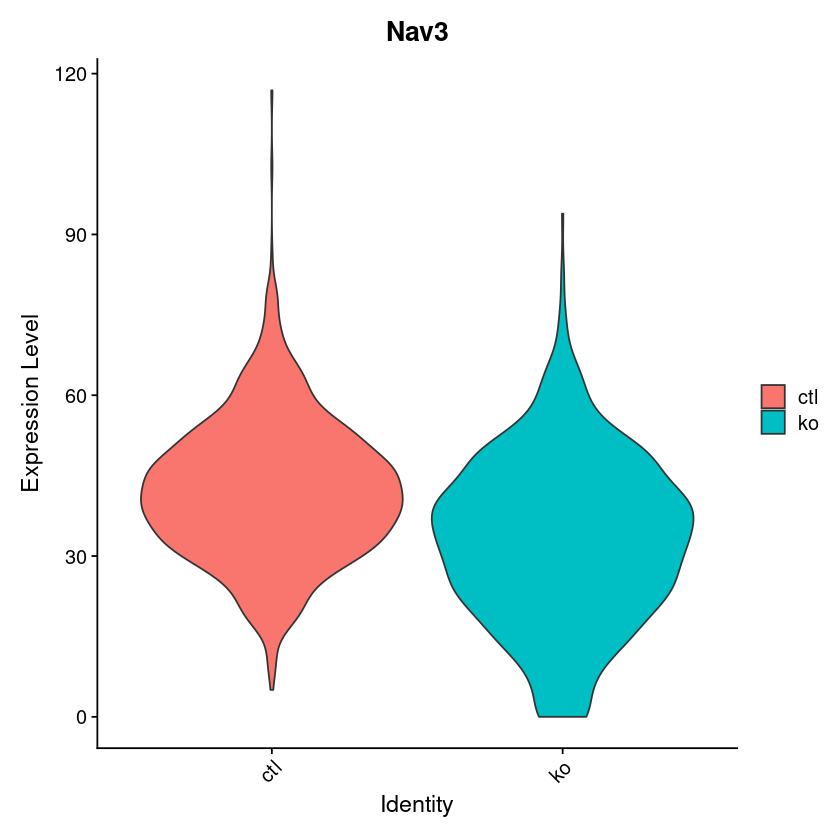

In [115]:
VlnPlot(l23, features = 'Nav3', pt.size = 0)

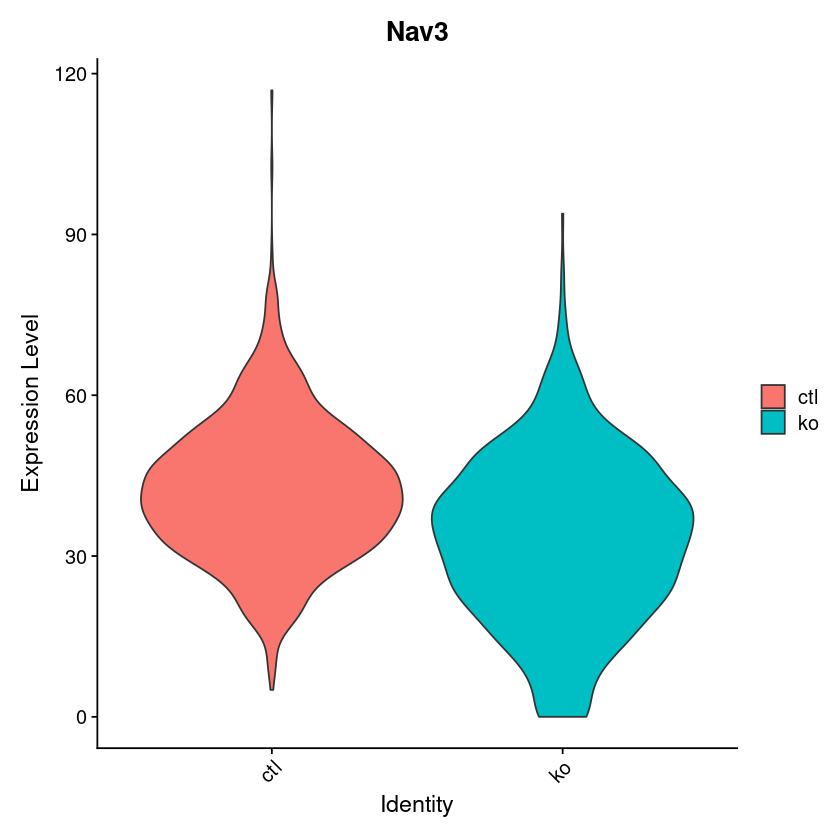

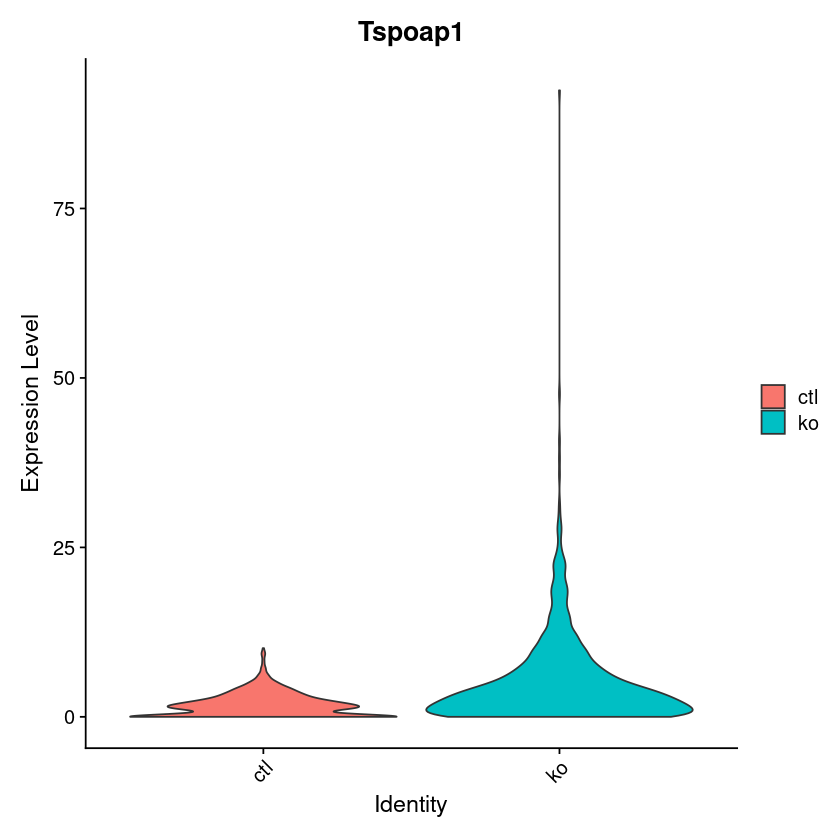

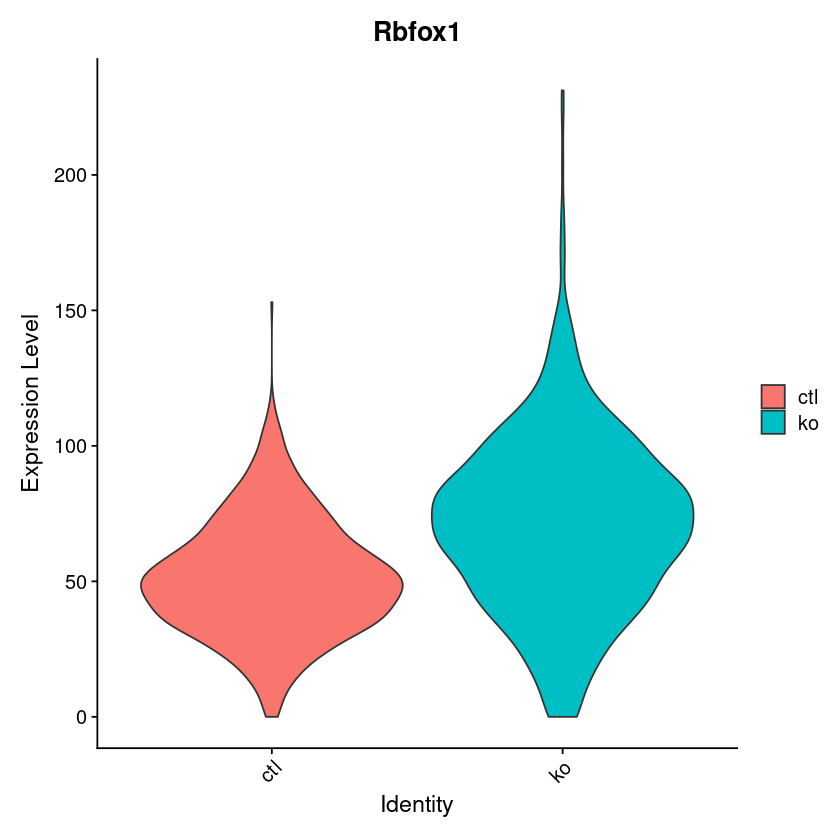

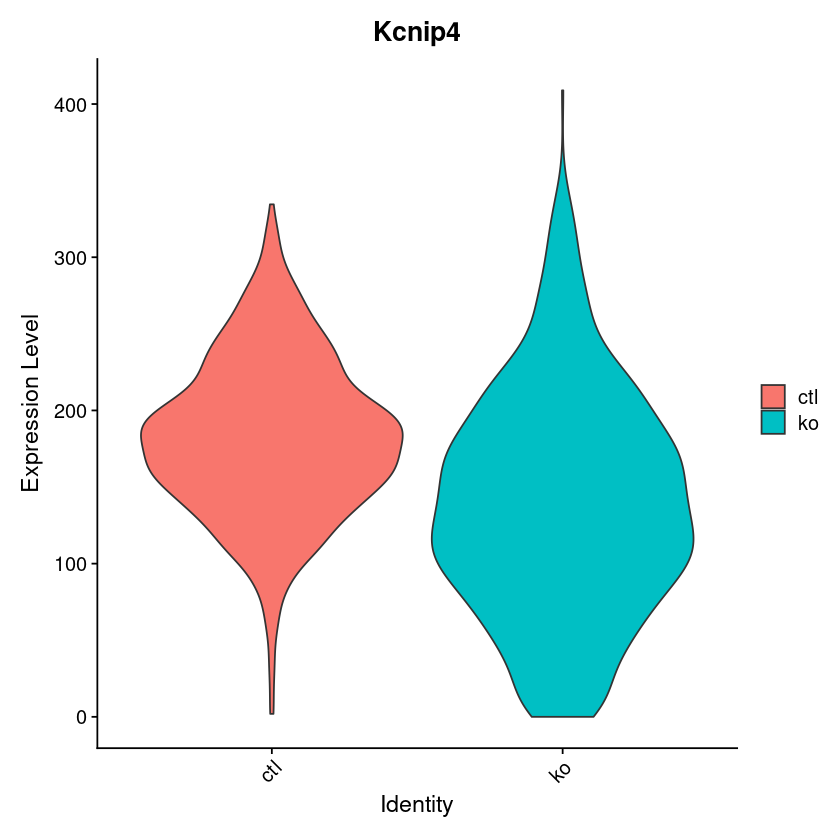

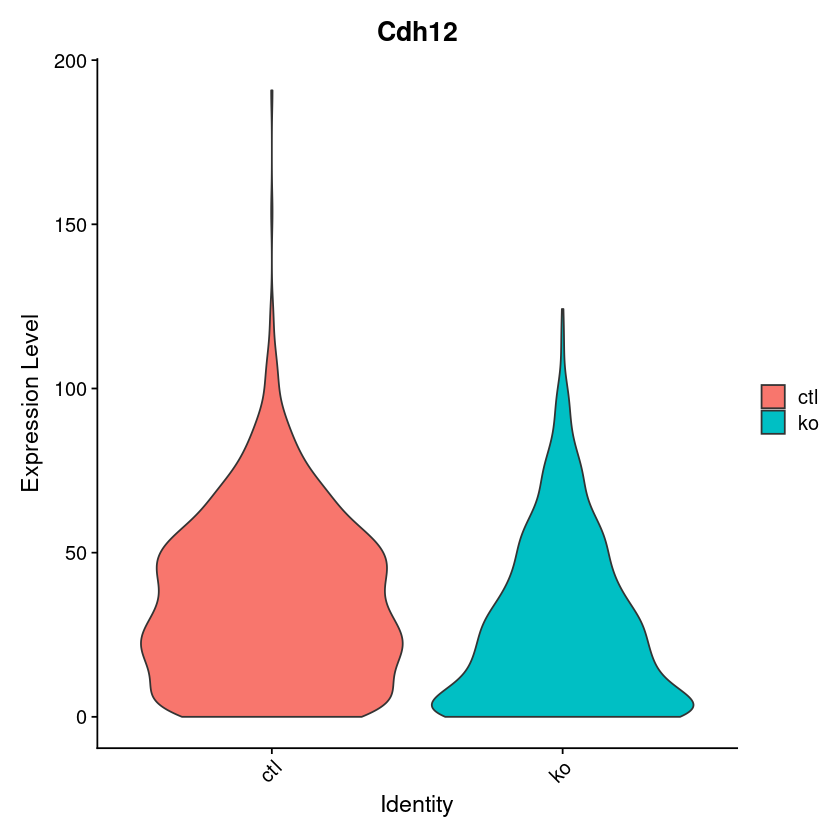

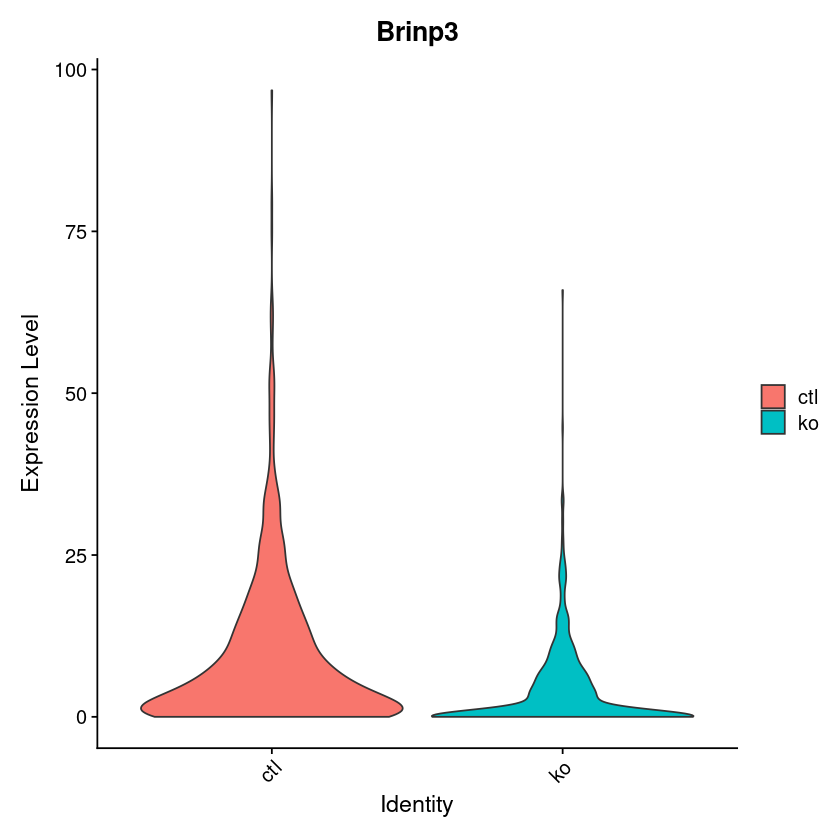

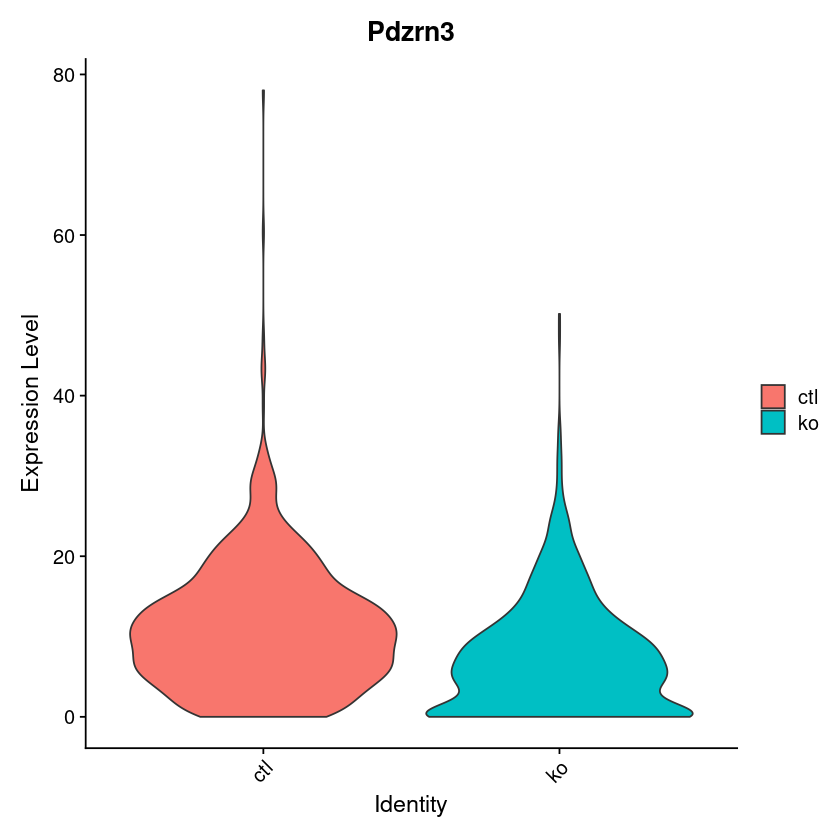

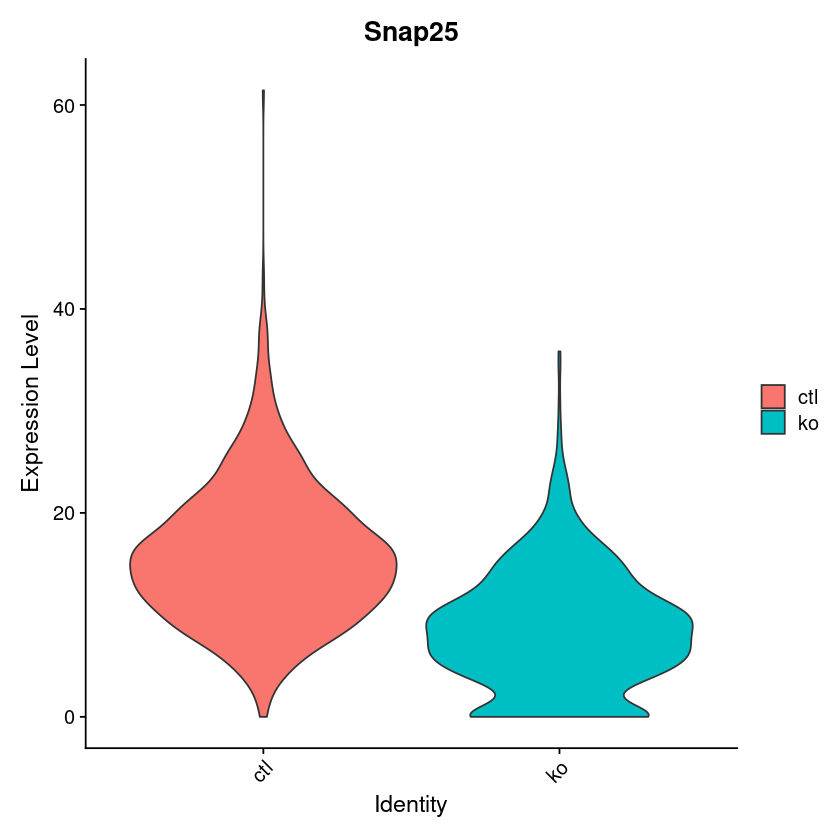

In [106]:
VlnPlot(l23, features = 'Nav3', pt.size = 0)
VlnPlot(l23, features = 'Tspoap1', pt.size = 0)
VlnPlot(l23, features = 'Rbfox1', pt.size = 0)
VlnPlot(l23, features = 'Kcnip4', pt.size = 0)

VlnPlot(l23, features = 'Cdh12', pt.size = 0)
VlnPlot(l23, features = 'Brinp3', pt.size = 0)
VlnPlot(l23, features = 'Pdzrn3', pt.size = 0)
VlnPlot(l23, features = 'Snap25', pt.size = 0)

In [ ]:
l23.ko <- subset(l23, subset = condition == 'ko')
table(l23.ko[[]]$neighbors)

l23.wt <- subset(l23, subset = condition == 'ctl')
table(l23.wt[[]]$neighbors)